모든 데이터 기본
* x
  * (데이터 수, 32, 32, 3)
  * 정규화 [0~1]
* y 
  * (데이터 수, 12) [원핫인코딩]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB


# 1. 준비

## 1.1. import

In [4]:
import numpy as np
import pandas as pd
import os
import gzip
import urllib.request
import natsort
import matplotlib.pyplot as plt
import cv2
import random


from PIL import Image
from keras.models import load_model

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout


from sklearn.model_selection import train_test_split

## 1.2. Train & Test 데이터 로드

In [5]:
metainfo = pd.read_csv("Meta.csv")
traininfo = pd.read_csv("Train.csv")
testinfo = pd.read_csv("Test.csv")

In [6]:
def matching_labels(unmatched_labels):
    """
    3~38 라벨들이 담긴 리스트 -> 0~11 라벨들이 담긴 nparray
    """
    real_classes = [3,7,9,10,11,12,13,17,18,25,35,38]
    matching_real_classes = [[np.where(np.array(unmatched_labels) == real_class)[0]] for real_class in real_classes]
  
    matched_labels = -np.ones(len(unmatched_labels))
    real_class = 0
    for matching_real_class in matching_real_classes:
        for idx in matching_real_class:
            matched_labels[idx] = real_class
        real_class += 1
    if -1 in matched_labels:
        print("3~38 -> 0~11 라벨 매칭 잘못 되었음") # 여기는 프린트 되면 안 되는 부분 (확인용)
    return np.array(matched_labels)

class GTSRB_train:
    def __init__(self):
        real_classes = [3,7,9,10,11,12,13,17,18,25,35,38]
        datas = [] # 이미지 담을 리스트
        labels = [] # 라벨 담을 리스트
        for real_class in real_classes:
            imgs_path = "Train/" + str(real_class)
            num = 0
            for img in os.listdir(imgs_path):
                im = Image.open(imgs_path +'/'+ img)
                im = np.array(im.resize((32,32)))
                datas.append(im)
                labels.append(real_class)
                num += 1
                if num == 1000:
                    print(f'Train : real_class 중 [{real_class}] 완료')
                    break;

        labels = to_categorical(matching_labels(labels))
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(np.array(datas), labels, test_size=0.1)
        self.x_train, self.x_val = self.x_train/255, self.x_val/255 # 정규화

class GTSRB_test:
    def __init__(self):
        real_classes = [3,7,9,10,11,12,13,17,18,25,35,38]
        datas = []
        labels = np.array([testinfo.ClassId[i] for i in range(len(testinfo.ClassId))])
        for img in natsort.natsorted(os.listdir("Test")):
            im = Image.open("Test/"+ img)
            im = np.array(im.resize((32,32)))
            datas.append(im)

        labels_test_idx = []
        for i in range(len(labels)):
            if labels[i] in real_classes:
                labels_test_idx.append(i)
            if len(labels_test_idx)%1000 == 0:
                print(f"Test :{len(labels_test_idx)}")

        test_data = []
        test_label = []
        for idx in labels_test_idx:
            test_data.append(datas[idx])
            test_label.append(labels[idx])
        self.x_test = np.array(test_data)/255
        self.y_test = to_categorical(matching_labels(test_label))   

In [8]:
data_train = GTSRB_train()
data_test = GTSRB_test()
# train & test 총 약 11분

print("===== TRAIN =====")
# x_train : (10800, 32, 32, 3), 정규화 완료 (0~1)
print(data_train.x_train.shape)
print(np.min(data_train.x_train), np.max(data_train.x_train))
# x_val : (1200, 32, 32, 3), 정규화 완료 (0~1)
print(data_train.x_val.shape)
print(np.min(data_train.x_val), np.max(data_train.x_val))
# y_train : (10800, 12) : 0~11 원핫인코딩
print(data_train.y_train.shape)
# y_val : (1200, 12) : 0~11 원핫인코딩
print(data_train.y_val.shape)

print("===== TEST =====")
# x_train : (10800, 32, 32, 3), 정규화 완료 (0~1)
print(data_test.x_test.shape)
print(np.min(data_test.x_test), np.max(data_test.x_test))
# y_train : (10800, 12) : 0~11 원핫인코딩
print(data_test.y_test.shape)

Train : real_class 중 [3] 완료
Train : real_class 중 [7] 완료
Train : real_class 중 [9] 완료
Train : real_class 중 [10] 완료
Train : real_class 중 [11] 완료
Train : real_class 중 [12] 완료
Train : real_class 중 [13] 완료
Train : real_class 중 [17] 완료
Train : real_class 중 [18] 완료
Train : real_class 중 [25] 완료
Train : real_class 중 [35] 완료
Train : real_class 중 [38] 완료
Test :0
Test :0
Test :1000
Test :2000
Test :3000
Test :3000
Test :3000
Test :3000
Test :4000
Test :5000
Test :6000
===== TRAIN =====
(10800, 32, 32, 3)
0.0 1.0
(1200, 32, 32, 3)
0.0 1.0
(10800, 12)
(1200, 12)
===== TEST =====
(6180, 32, 32, 3)
0.0 1.0
(6180, 12)


## 1.3. CNN

In [9]:
cd ../공모전용

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/공모전용


In [10]:
def train(data, file_name, num_epochs=50, batch_size=128):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    IMG_HEIGHT = 32
    IMG_WIDTH = 32

    # 첫번째 Convolutional Layer : 입력 데이터로부터 특징을 추출
    model.add(Conv2D(filters=96, kernel_size=3, activation='relu', input_shape=data.x_train.shape[1:]))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    # 두번째 Convolutional Layer
    model.add(Conv2D(filters=192, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25)) # 인풋데이터의 25%를 무작위로 0으로 만듦

    # 세번째 Convolutional Layer
    model.add(Conv2D(filters=192, kernel_size=3, activation='relu')) # 특징을 추출하는 기능을 하는 필터, 비선형 값으로 바꿔주는 activation 함수->relu
    # model.add(GlobalAveragePooling2D())
    model.add(Flatten())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(12, activation='softmax'))

    # 모델 컴파일 하기
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    # 모델 핏하기
    EPOCHS = num_epochs
    model.fit(data.x_train, data.y_train,
              validation_data = (data.x_val, data.y_val), 
              epochs=EPOCHS, steps_per_epoch=60
              )

    if file_name != None:
        model.save(file_name)

    return model

In [11]:
#@title CNN parameter load option
load_param = True #@param {type:"boolean"}
save_new_file = False #@param {type:"boolean"}

if load_param == False:
  if save_new_file == True:
    fname = "cnn_train_model.h5"
  elif save_new_file == False:
    fname = None
  model = train(data_train, fname, num_epochs=30)
elif load_param == True:
  model = load_model('cnn_train_model.h5')

In [12]:
loss, accuracy = model.evaluate(data_train.x_train, data_train.y_train)
print('train set accuracy: ', accuracy * 100) # train 성능

loss, accuracy = model.evaluate(data_train.x_val, data_train.y_val)
print('valid set accuracy: ', accuracy * 100) # val 성능

loss, accuracy = model.evaluate(data_test.x_test, data_test.y_test)
print('test set accuracy with nomalization: ', accuracy * 100) # test 성능

338/338 [==============================] - 17s 50ms/step - loss: 5.9679e-04 - accuracy: 0.9999
train set accuracy:  99.99074339866638
38/38 [==============================] - 2s 49ms/step - loss: 4.4796e-04 - accuracy: 1.0000
valid set accuracy:  100.0
194/194 [==============================] - 10s 50ms/step - loss: 0.0304 - accuracy: 0.9636
test set accuracy with nomalization:  96.35922312736511


# 2. Generate Adversarial examples : FGSM & PGD

## 2.1. processing

In [13]:
def tf_preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (32, 32))
  image = image[None, ...]
  return image

# 확률 벡터에서 레이블을 추출해주는 헬퍼 메서드
def get_tf_label(labels):
    label = tf.cast(labels, tf.int32)
    label = tf.reshape(label,[1,12])
    return label

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    input_img = tf.reshape(input_image,[1,32,32,3])
    prediction = model(input_img)
    loss = loss_object(input_label, prediction)

  # 입력 이미지에 대한 손실 함수의 기울기를 구합니다.
  gradient = tape.gradient(loss, input_image)
  # 왜곡을 생성하기 위해 그래디언트의 부호를 구합니다.
  signed_grad = tf.sign(gradient)
  return signed_grad

## 2.2. FGSM

In [14]:
def fgsm_attack(model,test_x,test_y,eps):
    
    prog = 0 # 진행상황 확인용 변수

    correct = 0
    adv_examples = []
    save_adv_examples = [] # 공격받은 이미지들이 저장될 리스트
    save_original_output = [] # 공격받은 이미지들의 정답 라벨 값이 저장될 리스트
    
    for i in range(len(test_x)):
        # 1장의 이미지와 그 label
        data = test_x[i]
        target_onehot = test_y[i] # one-hot 형태
        target_label = int(np.argmax(target_onehot)) # label 형태

        # model이 정상 데이터를 분류한 결과 (각각 one-hot 형태, int label 형태)
        result_onehot = model.predict(data.reshape(1,32,32,3)) # one-hot 형태
        result_label = int(np.argmax(result_onehot))

        # 모델이 정상 데이터인데도 잘못 분류했다면 사용하지 않는다 (아래 코드 실행하지 않고 다음 이미지로 넘어감)
        if target_label != result_label:
            continue

        # 이미지 전처리
        img =  tf_preprocess(data) # 텐서플로 전처리
        label = get_tf_label(target_onehot) # 확률벡터에서 레이블 추출
        
        # FGSM 공격 수행
        perturbations = create_adversarial_pattern(img, label)
        adv_x = img + eps * perturbations
        adv_x = tf.clip_by_value(adv_x, 0, 1) # 공격받은 이미지

        # 공격 이미지를 분류기에 넣은 결과; 잘못 분류되어야 할 것 
        atkresult_onehot = model.predict(adv_x) # one-hot 형태
        atkresult_label = int(np.argmax(atkresult_onehot)) # label 형태

        # 만약 공격 받아도 제대로 분류된다면 correct로 count
        if atkresult_label == target_label:
            correct += 1
        
        # 공격 적용된 이미지, 그 공격 받은 이미지의 원래 정답 label을 각각 리스트에 저장합니다
        save_adv_examples.append(tf.reshape(adv_x,[32,32,3]))
        save_original_output.append(target_label)

        prog += 1

        if prog%500 == 0:
          print("prog :", prog)

    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_x))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_x), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples, save_adv_examples, save_original_output

## 2.3. PGD

In [15]:
def pgd_attack(model,test_x,test_y,eps,step_size=2,num_steps=7): 
    """
    FGSM 코드와 차이점
    - step_size, num_steps 파라미터 추가됨
    - unifrom distribution 코드 추가
    - FGSM 공격 수행 -> PGD 공격 수행
    ** 모든 return 형식은 동일함
    
    default 값
    - step_size = 2 (alpha 값)
    - num_steps = 7 (iterations 값)

    """

    prog = 0 # 진행상황 확인용 변수

    correct = 0
    adv_examples = []
    save_adv_examples = [] # 공격받은 이미지들이 저장될 리스트
    save_original_output = [] # 공격받은 이미지들의 정답 라벨 값이 저장될 리스트
    
    for i in range(len(test_x)):
        # 1장의 이미지와 그 label
        data = test_x[i]
        target_onehot = test_y[i] # one-hot 형태
        target_label = int(np.argmax(target_onehot)) # label 형태

        # model이 정상 데이터를 분류한 결과 (각각 one-hot 형태, int label 형태)
        result_onehot = model.predict(data.reshape(1,32,32,3)) # one-hot 형태
        result_label = int(np.argmax(result_onehot))

        # 모델이 정상 데이터인데도 잘못 분류했다면 사용하지 않는다 (아래 코드 실행하지 않고 다음 이미지로 넘어감)
        if target_label != result_label:
            continue

        # PGD uniform distribution 코드
        data = data + np.random.uniform(-eps,eps,data.shape)
        data = np.clip(data,0,255)

        # 이미지 전처리
        img =  tf_preprocess(data) # 텐서플로 전처리 -> 0~1사이로 정규화 함.
        label = get_tf_label(target_onehot) # 확률벡터에서 레이블 추출
        
        # PGD 공격 수행
        adv_x = img # 공격받은 이미지 (for문으로 업데이트)
        for num_step in range(num_steps):
          perturbations = create_adversarial_pattern(adv_x,label) # signed_grad를 리턴한 값
          adv_x += step_size * perturbations
          adv_x = tf.clip_by_value(adv_x,img-eps,img+eps)
          adv_x = tf.clip_by_value(adv_x,0,1)

        # 공격 이미지를 분류기에 넣은 결과; 잘못 분류되어야 할 것 
        atkresult_onehot = model.predict(adv_x) # one-hot 형태
        atkresult_label = int(np.argmax(atkresult_onehot)) # label 형태

        # 만약 공격 받아도 제대로 분류된다면 correct로 count
        if atkresult_label == target_label:
            correct += 1
        
        # 공격 적용된 이미지, 그 공격 받은 이미지의 원래 정답 label을 각각 리스트에 저장합니다
        save_adv_examples.append(tf.reshape(adv_x,[32,32,3]))
        save_original_output.append(target_label) #공격 받은 이미지에 원래 타겟 값을 저장합니다 ! 

        prog += 1

        if prog%500 == 0:
          print("prog :", prog)

    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_x))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_x), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples, save_adv_examples, save_original_output

## 2.4. Adversarial Examples Generation

In [16]:
#@title Adversarial Example option : 공격 데이터 설정

attack_type = 'FGSM' #@param ["FGSM", "PGD"]
eps = 0.1 #@param [0.02, 0.03, 0.04, 0.05, 0.08, 0.10] {type:"raw"}

In [ ]:
if attack_type == "FGSM":
  train_acc, train_ex, train_ad_examples, train_orig_labels = fgsm_attack(model, data_train.x_train, data_train.y_train, eps) #x 공격데이터 : 0~1 정규화 완료, y 데이터 : 12개 라벨
  valid_acc, valid_ex, val_ad_examples, val_orig_labels = fgsm_attack(model, data_train.x_val, data_train.y_val, eps)
  test_acc, test_ex, test_ad_examples, test_orig_labels = fgsm_attack(model, data_test.x_test, data_test.y_test, eps)

elif attack_type == "PGD":
  train_acc, train_ex, train_ad_examples, train_orig_labels = pgd_attack(model, data_train.x_train, data_train.y_train, eps) #x 공격데이터 : 0~1 정규화 완료, y 데이터 : 12개 라벨
  valid_acc, valid_ex, val_ad_examples, val_orig_labels = pgd_attack(model, data_train.x_val, data_train.y_val, eps)
  test_acc, test_ex, test_ad_examples, test_orig_labels = pgd_attack(model, data_test.x_test, data_test.y_test, eps)

print("Attack Data 생성 완료")

prog : 500
prog : 1000
prog : 1500
prog : 2000
prog : 2500
prog : 3000
prog : 3500
prog : 4000
prog : 4500
prog : 5000
prog : 5500
prog : 6000
prog : 6500
prog : 7000
prog : 7500
prog : 8000
prog : 8500
prog : 9000
prog : 9500
prog : 10000
prog : 10500
Epsilon: 0.1	Test Accuracy = 2206 / 10800 = 0.20425925925925925
prog : 500
prog : 1000
Epsilon: 0.1	Test Accuracy = 252 / 1200 = 0.21
prog : 500
prog : 1000
prog : 1500
prog : 2000
prog : 2500
prog : 3000
prog : 3500
prog : 4000
prog : 4500
prog : 5000
prog : 5500
Epsilon: 0.1	Test Accuracy = 1198 / 6180 = 0.19385113268608414
Attack Data 생성 완료


# 3. Fourier for Detection

## 3.0.0. 푸리에 정의

In [ ]:
def Fourier_transform(img):
  f = np.fft.fft2(img) # 이미지에 푸리에 변환 적용
  fshift = np.fft.fftshift(f) # 분석을 용이하게 하기 위해 주파수가 0인 부분을 중앙에 위치시킴. 중앙에 저주파가 모이게 됨.
  
  mag_spectrum = 20*np.log(np.abs(fshift)) # spectrum 구하는 수학식.
  if np.min(mag_spectrum) < 0:
    mag_spectrum -= np.min(mag_spectrum) # 0~???로 변환

  if np.min(mag_spectrum) < 0: # 확인용; 프린트 X
    print("### 나오면 안됨 ### 0보다 작은 값 안 없어짐", np.min(mag_spectrum))

  maxval = np.max(mag_spectrum)
  if maxval <= 0:
    print("### maxval 0 이하인 경우 있음 ### ")
    maxval += 1e-6

  mag_spectrum = mag_spectrum/maxval # 0~1 정규화

  if np.max(mag_spectrum) < 0 or np.min(mag_spectrum) < 0:
    print("### 0보다 작은 값 남아있음 ###")
  
  mag_spectrum = mag_spectrum * 255
  mag_spectrum = (mag_spectrum.astype(int))
  # print("min :", np.min(mag_spectrum), "max :", np.max(mag_spectrum))

  if np.max(mag_spectrum) > 255: # 확인용; 프린트 X
    print("### 나오면 안됨 ### 1보다 큰 값 있음")

  return mag_spectrum

In [ ]:
class FouBin_train:
  def __init__(self):
    # train - original : 1 (True)
    x_ori = data_train.x_train
    y_ori = np.ones(len(x_ori))
    # train - adversarial : 0 (False)
    x_adv = train_ad_examples
    y_adv = np.zeros(len(x_adv))
    # validation - original : 1 (True)
    x_ori_val = data_train.x_val
    y_ori_val = np.ones(len(x_ori_val))
    # validation - adversarial : 0 (False)
    x_adv_val = val_ad_examples
    y_adv_val = np.zeros(len(x_adv_val))

    # train용 & validation용 concat =============================================
    temp_train_x = np.concatenate((x_ori, x_adv))
    temp_train_y = np.concatenate((y_ori, y_adv))
    temp_val_x = np.concatenate((x_ori_val, x_adv_val))
    temp_val_y = np.concatenate((y_ori_val, y_adv_val))

    shuff_train = list(range(len(temp_train_x)))
    random.shuffle(shuff_train)
    shuff_val = list(range(len(temp_val_x)))
    random.shuffle(shuff_val)

    # train ====================================================================
    x_train = []
    f_train = []
    bin_train = []
    train_prog = 0
    for train_idx in shuff_train:
      x_train.append(temp_train_x[train_idx])
      f_train.append(Fourier_transform(temp_train_x[train_idx]))
      bin_train.append(temp_train_y[train_idx])
      train_prog += 1
      if train_prog%500 == 0:
        print("train prog :", train_prog)
    x_train = np.array(x_train)
    f_train = np.array(f_train)
    bin_train = np.array(bin_train)
    # bin_train = to_categorical(bin_train)
    
    # val ======================================================================   
    x_val = []
    f_val = []
    bin_val = []
    val_prog = 0
    for val_idx in shuff_val:
      x_val.append(temp_val_x[val_idx])
      f_val.append(Fourier_transform(temp_val_x[val_idx]))
      bin_val.append(temp_val_y[val_idx])
      val_prog += 1
      if val_prog%500 == 0:
        print("val prog :", val_prog)
    x_val = np.array(x_val)
    f_val = np.array(f_val)
    bin_val = np.array(bin_val)
    # bin_val = to_categorical(bin_val)

    self.x_train, self.f_train, self.bin_train = x_train, f_train, bin_train
    self.x_val, self.f_val, self.bin_val = x_val, f_val, bin_val

class FouBin_test:
  def __init__(self):
    # test - original :1 (True)
    x_ori_test = data_test.x_test
    y_ori_test = np.ones(len(x_ori_test))
    # test - adversarial : 0 (False)
    x_adv_test = test_ad_examples
    y_adv_test = np.zeros(len(x_adv_test))

    # test용 concat ============================================================
    temp_test_x = np.concatenate((x_ori_test, x_adv_test))
    temp_test_y = np.concatenate((y_ori_test, y_adv_test))

    shuff_test = list(range(len(temp_test_x)))
    random.shuffle(shuff_test)

    # test =====================================================================
    x_test = []
    f_test = []
    bin_test = []
    test_prog = 0
    for test_idx in shuff_test:
      x_test.append(temp_test_x[test_idx])
      f_test.append(Fourier_transform(temp_test_x[test_idx]))
      bin_test.append(temp_test_y[test_idx])
      test_prog += 1
      if test_prog%500 == 0:
        print("test prog :", test_prog)
    x_test = np.array(x_test)
    f_test = np.array(f_test)
    bin_test = np.array(bin_test)
    # bin_test = to_categorical(bin_test)

    self.x_test, self.f_test, self.bin_test = x_test, f_test, bin_test

In [ ]:
fourier_train = FouBin_train()
fourier_test = FouBin_test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys


train prog : 500
train prog : 1000
train prog : 1500
train prog : 2000
train prog : 2500
train prog : 3000
train prog : 3500
train prog : 4000
train prog : 4500
train prog : 5000
train prog : 5500
train prog : 6000
train prog : 6500
train prog : 7000
train prog : 7500
train prog : 8000
train prog : 8500
train prog : 9000
train prog : 9500
train prog : 10000
train prog : 10500
train prog : 11000
train prog : 11500
train prog : 12000
train prog : 12500
train prog : 13000
train prog : 13500
train prog : 14000
train prog : 14500
train prog : 15000
train prog : 15500
train prog : 16000
train prog : 16500
train prog : 17000
train prog : 17500
train prog : 18000
train prog : 18500
train prog : 19000
train prog : 19500
train prog : 20000
train prog : 20500
train prog : 21000
train prog : 21500
val prog : 500
val prog : 1000
val prog : 1500
val prog : 2000
test prog : 500
test prog : 1000
test prog : 1500
test prog : 2000
test prog : 2500
test prog : 3000
test prog : 3500
test prog : 4000
test 

## 3.0.1 푸리에 비교

* 정상 & Adv 비교 : 같은 이미지에 대해

In [ ]:
norimg = data_train.x_train[:5]
advimg = train_ad_examples[:5]

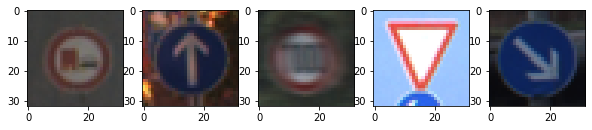

In [ ]:
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(norimg[i])

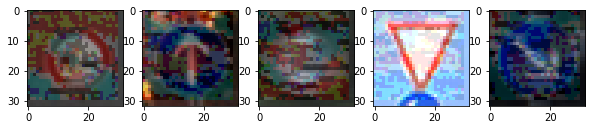

In [ ]:
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(advimg[i])

In [ ]:
fnorimg = Fourier_transform(norimg)
fadvimg = Fourier_transform(advimg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys


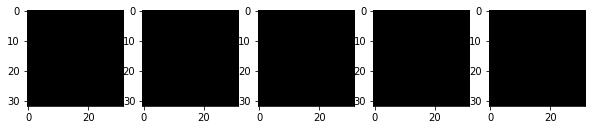

In [ ]:
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(fnorimg[i])

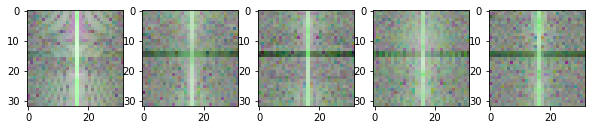

In [ ]:
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(fadvimg[i])

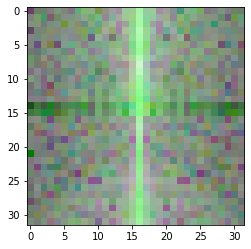

In [ ]:
iii = fourier_train.f_train[0]
plt.imshow(iii)

## 3.1. Fourier Train

In [ ]:
def model_detector(data, file_name, num_epochs=50, batch_size=128):
    # 참고 : https://velog.io/@eodud0582/cnn-ox-image-classification
    
    # 함성곱 신경망 모델 구성하기
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    model.summary() # 신경망의 구조 확인
    
    # 모델 컴파일
    # compile() 메서드를 이용해서 손실 함수 (loss function)와 옵티마이저 (optimizer)를 지정
    model.compile(optimizer=RMSprop(learning_rate=0.001), # 옵티마이저로는 RMSprop 사용
                  loss='binary_crossentropy', # 손실 함수로 ‘binary_crossentropy’ 사용
                  metrics= ['accuracy'])
    # RMSprop (Root Mean Square Propagation) Algorithm: 훈련 과정 중에 학습률을 적절하게 변화시킨다.
    
    # # 모델 훈련
    model.fit(data.x_train, data.bin_train, # f -> x
              validation_data = (data.x_val, data.bin_val), # f -> x
              epochs=num_epochs, steps_per_epoch=60
               )
    
    if file_name != None:
      model.save(file_name)

    return model

In [ ]:
#@title CNN detector load option
load_param_for_detector = True #@param {type:"boolean"}
save_new_file_for_detector = False #@param {type:"boolean"}


if load_param_for_detector == False:
  if save_new_file_for_detector == True:
    fname = "Detector_param.h5"
  elif save_new_file_for_detector == False:
    fname = None
  detector = model_detector(fourier_train, fname, num_epochs=15)
elif load_param == True:
  detector = load_model('Detector_param.h5')

In [ ]:
loss, accuracy = detector.evaluate(fourier_train.f_train, fourier_train.bin_train)
print('train set accuracy: ', accuracy * 100) # train 성능

loss, accuracy = detector.evaluate(fourier_train.f_val, fourier_train.bin_val)
print('validation set accuracy: ', accuracy * 100) # val 성능

675/675 [==============================] - 7s 10ms/step - loss: 0.1832 - accuracy: 0.9338
train set accuracy:  93.37932467460632
75/75 [==============================] - 1s 10ms/step - loss: 0.1779 - accuracy: 0.9362
validation set accuracy:  93.62499713897705


## 3.2. Fourier Test

In [ ]:
loss, accuracy = detector.evaluate(fourier_test.f_test, fourier_test.bin_test)
print('test set accuracy: ', accuracy * 100) # test 성능

380/380 [==============================] - 4s 10ms/step - loss: 0.1851 - accuracy: 0.9388
test set accuracy:  93.87721419334412
